In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import qnmfits
import analytic_fit
import utils
import corner

plt.rcParams.update(utils.rcparams)

In [2]:
t0_M = pd.read_csv('../data/t0_data_30_to_100.csv', index_col=0)

We can get an idea of whether our choice of the noise floor is conservative enough with the following process:

1. Create an injection based on a CCE waveform, which includes the $(3,2,0)$ mode. Perhaps ideally you would want to pick the $(3,2,0)$ amplitude carefully from a stable window.
2. Perform a Bayesian fit to the injection where we don't include the $(3,2,0)$ mode in our model, but attempt to compensate with a appropriate choice of $\sigma$.
3. If the truths lie within the 90% credible region, then the choice of $\sigma$ is sufficient.

In [3]:
ID = 1
N = 11
T = 100

In [4]:
t0 = t0_M[str(ID)].values[N]

In [5]:
# Create an injection. This simply performs a least-squares fit to the (2,2)
# mode of the simulation with the requested ID, and builds a waveform from
# the fitted complex amplitudes. The start time is chosen from the mismatch
# curve.
injection_info, injection_C, injection_omega = utils.injection(
    ID = 1,
    N = N,
    tref=t0_M['1'].values[N],
    additional_modes=[(3,2,0,1)],
    returnC=True
)
injection = injection_info['sim']

In [6]:
t0, injection.times[0]

(np.float64(-4.765156176626988), np.float64(-4.765156176626988))

In [7]:
A320 = np.abs(injection_C[-1])
A320

np.float64(0.0029584785446042368)

In [8]:
re_c_truths = np.real(injection_C)
im_c_truths = np.imag(injection_C)

c_truths = []
for re_c, im_c in zip(re_c_truths, im_c_truths):
    c_truths.append(re_c)
    c_truths.append(im_c)

In [9]:
injection.chif_mag, injection.Mf

(np.float64(0.6864419212995437), 0.9516192579323307)

In [10]:
sim_info = utils.load_cce_data(ID)
sim = sim_info['sim']
chif = sim.chif_mag
Mf = sim.Mf

chif, Mf

(np.float64(0.6864419212995437), 0.9516192579323307)

Check the values of $C_{320}$ agrees with the value obtained from a fit at later times with less overtones:

In [11]:
t0_list = np.linspace(10, 50, 41)
C_list = []
for t0_trial in t0_list:
    bf = qnmfits.ringdown_fit(
        sim.times,
        sim.h[2,2],
        modes=[(2,2,0,1),(2,2,1,1),(3,2,0,1)],
        Mf=Mf,
        chif=chif,
        t0=t0_trial,
        t0_method='closest',
        T=100
    )
    C_at_t0 = []
    for C, omega in zip(bf['C'], bf['frequencies']):
        C_at_t0.append(C*np.exp(-1j*omega*(t0 - t0_trial)))
    C_list.append(C_at_t0)

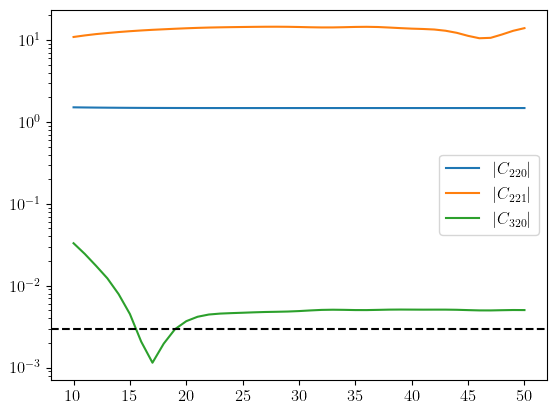

In [12]:
fig, ax = plt.subplots()
ax.set_yscale('log')

ax.plot(t0_list, np.abs([C[0] for C in C_list]), label='$|C_{220}|$')
ax.plot(t0_list, np.abs([C[1] for C in C_list]), label='$|C_{221}|$')
ax.plot(t0_list, np.abs([C[2] for C in C_list]), label='$|C_{320}|$')
ax.axhline(np.abs(injection_C[-1]), color='k', ls='--')

ax.legend();

So we're slightly underestimating the true $(3,2,0)$ amplitude from our large-overtone fit.

Perform some Bayesian fits...

In [13]:
injection_data = {
    'plus': np.real(injection.h[2,2]),
    'cross': -np.imag(injection.h[2,2]),
}

If we just use $\sigma = A_{320}$ this seems to be sufficient in this case:

In [14]:
analytic_samples, A_samples, phi_samples = analytic_fit.sample(
    times=injection.times,
    data=injection_data,
    sigma=A320*np.ones_like(injection.times),
    qnm_omegas=injection_omega[:-1],  # Exclude the (3,2,0) mode from the fit
    t0=t0,
    t0_method='closest',
    T=T,
    reweight=False,
)

In [15]:
modes = [(2, 2, n, 1) for n in range(N+1)]

In [16]:
real_labels = [
    rf'$\mathrm{{Re}}[C_{{{ell}{m}{n}}}]$' for (ell, m, n, _) in modes
]
imag_labels = [
    rf'$\mathrm{{Im}}[C_{{{ell}{m}{n}}}]$' for (ell, m, n, _) in modes
]
labels = []
for real, imag in zip(real_labels, imag_labels):
    labels.append(real)
    labels.append(imag)

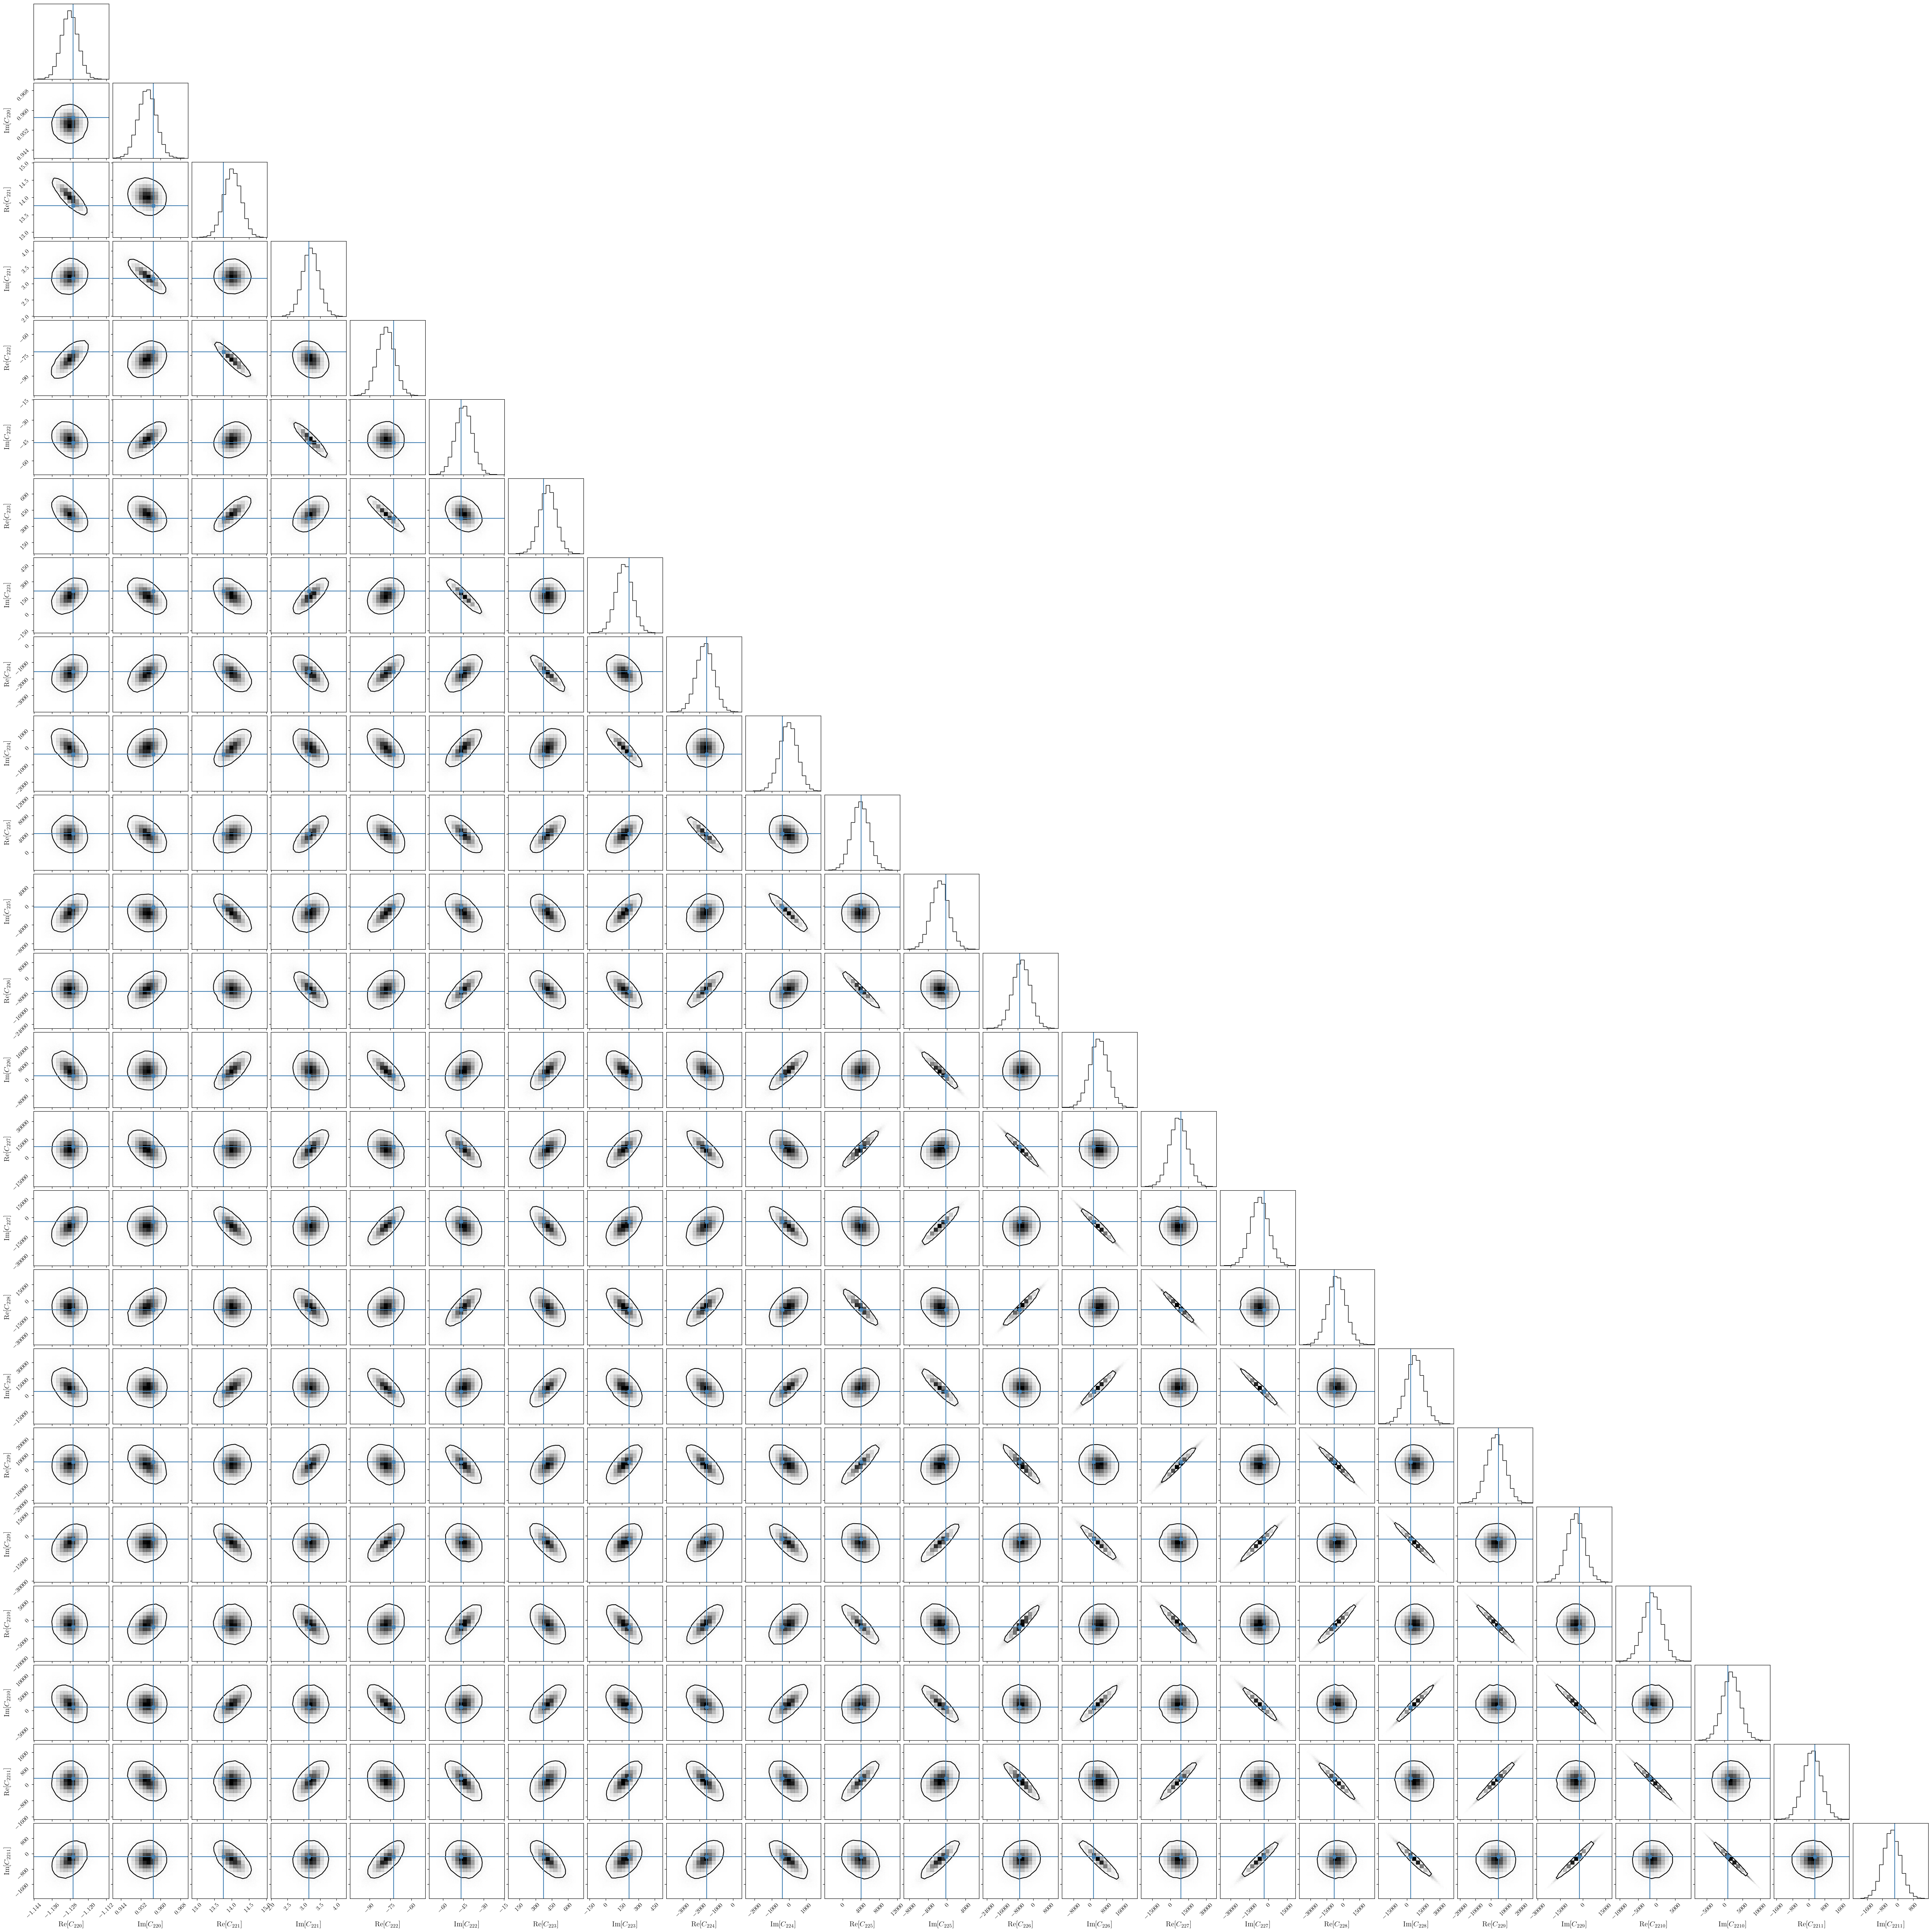

In [17]:
fig = corner.corner(
    analytic_samples,
    levels=[0.9],
    labels=labels,
    truths=c_truths[:-2],
    data_kwargs={
        'alpha': 0.005,
    },
    hist_kwargs={
        'density': True,
    }
)

In [18]:
for i, (truth, posterior) in enumerate(zip(c_truths, analytic_samples.T)):
    q5, q95 = np.percentile(posterior, [5, 95])
    if truth < q5 or truth > q95:
        print(f"Truth value for parameter {i} is outside the 90% credible interval ({q5}, {q95})")

If we use too small a sigma we run into problems...

In [19]:
analytic_samples, A_samples, phi_samples = analytic_fit.sample(
    times=injection.times,
    data=injection_data,
    sigma=A320*np.ones_like(injection.times)/5,
    qnm_omegas=injection_omega[:-1],  # Exclude the (3,2,0) mode from the fit
    t0=t0,
    t0_method='closest',
    T=T,
    reweight=False,
)

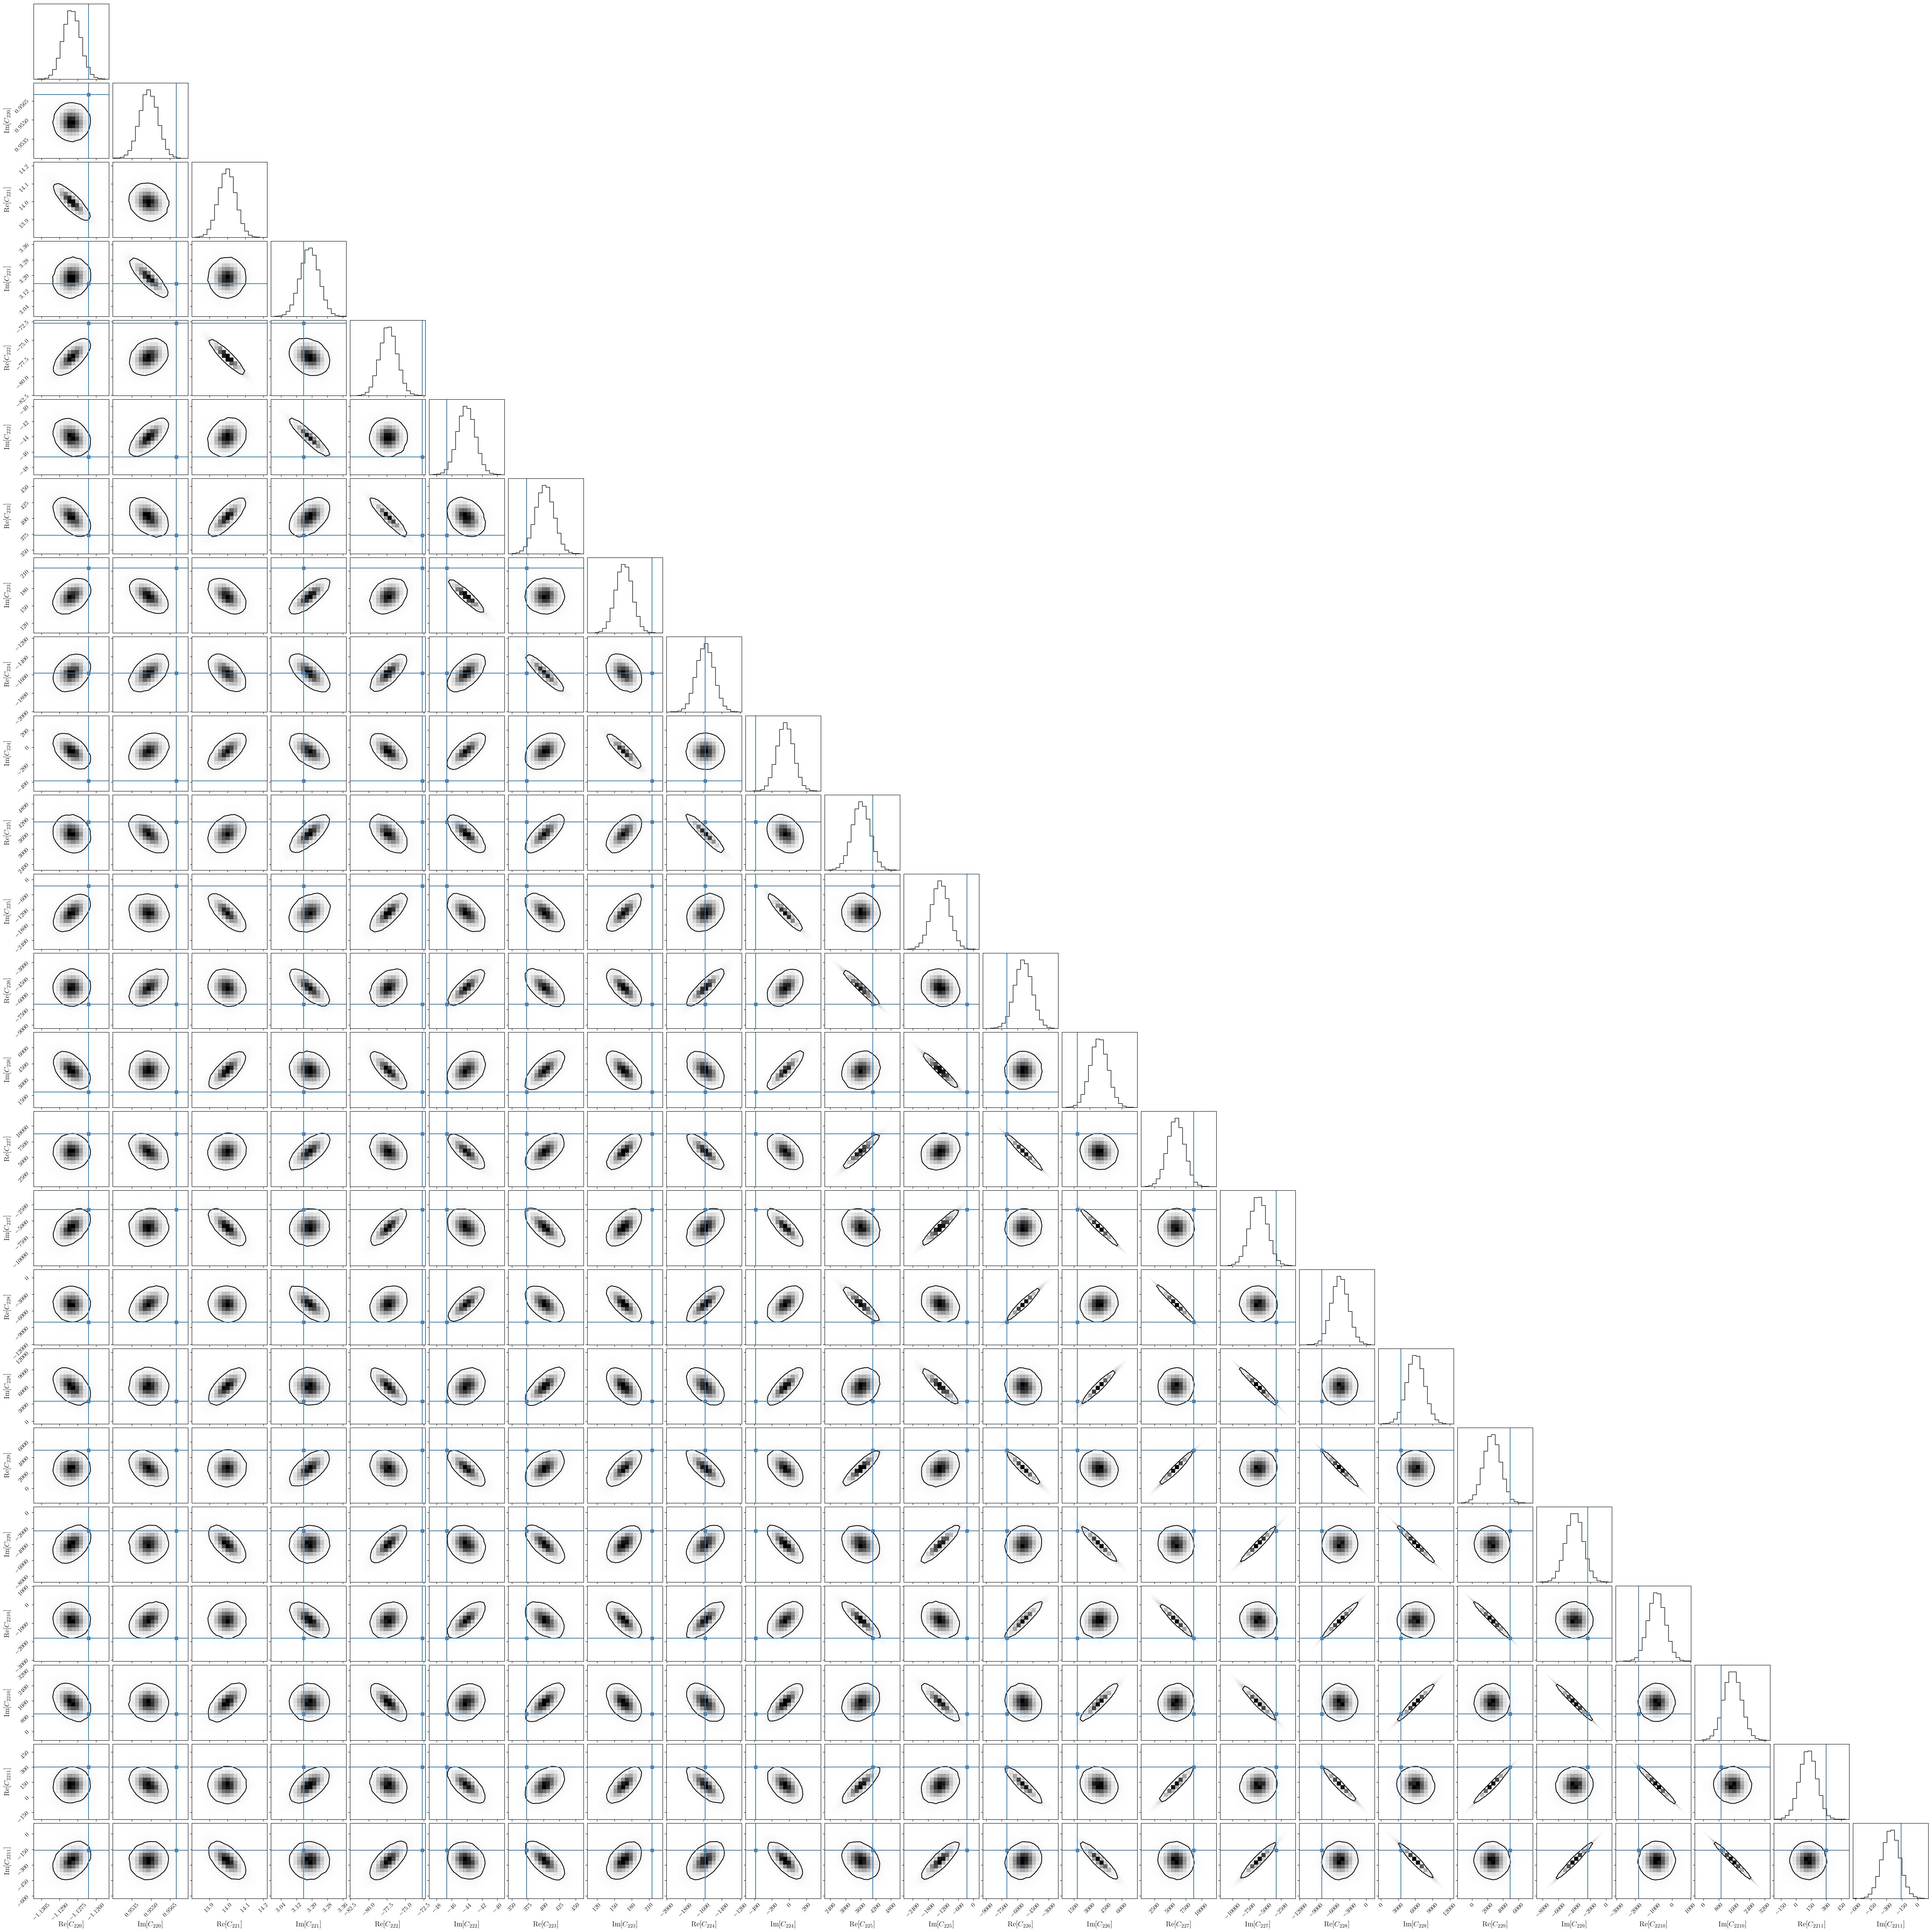

In [20]:
fig = corner.corner(
    analytic_samples,
    levels=[0.9],
    labels=labels,
    truths=c_truths[:-2],
    data_kwargs={
        'alpha': 0.005,
    },
    hist_kwargs={
        'density': True,
    }
)

In [21]:
for i, (truth, posterior) in enumerate(zip(c_truths, analytic_samples.T)):
    q5, q95 = np.percentile(posterior, [5, 95])
    if truth < q5 or truth > q95:
        print(f"Truth value for parameter {i} is outside the 90% credible interval ({q5}, {q95})")

Truth value for parameter 0 is outside the 90% credible interval (-1.1291829929691881, -1.1268065277063537)
Truth value for parameter 1 is outside the 90% credible interval (0.9536530070763686, 0.9560168631878183)
Truth value for parameter 2 is outside the 90% credible interval (13.918985957187209, 14.078030230024956)
Truth value for parameter 4 is outside the 90% credible interval (-79.22094349802542, -75.38227396971142)
Truth value for parameter 5 is outside the 90% credible interval (-45.988917238573336, -42.15478394025611)
Truth value for parameter 6 is outside the 90% credible interval (378.14208065052435, 425.17118457546553)
Truth value for parameter 7 is outside the 90% credible interval (143.267169768522, 190.17279034724595)
Truth value for parameter 9 is outside the 90% credible interval (-202.98583917335444, 111.77837252216952)
Truth value for parameter 11 is outside the 90% credible interval (-1890.406940950629, -737.9075404418444)
Truth value for parameter 12 is outside the

Repeat for all IDs

In [22]:
N = 11
T = 100

for ID in t0_M.columns:

    print(f'Injection based on CCE:{ID}:')

    t0 = t0_M[ID].values[N]

    injection_info, injection_C, injection_omega = utils.injection(
        ID = int(ID),
        N = N,
        tref=t0_M[ID].values[N],
        additional_modes=[(3,2,0,1)],
        returnC=True
    )
    injection = injection_info['sim']

    A320 = np.abs(injection_C[-1])

    re_c_truths = np.real(injection_C)
    im_c_truths = np.imag(injection_C)

    c_truths = []
    for re_c, im_c in zip(re_c_truths, im_c_truths):
        c_truths.append(re_c)
        c_truths.append(im_c)
    
    injection_data = {
        'plus': np.real(injection.h[2,2]),
        'cross': -np.imag(injection.h[2,2]),
    }

    analytic_samples, A_samples, phi_samples = analytic_fit.sample(
        times=injection.times,
        data=injection_data,
        sigma=A320*np.ones_like(injection.times),
        qnm_omegas=injection_omega[:-1],
        t0=t0,
        t0_method='closest',
        T=T,
        reweight=False,
    )

    for i, (truth, posterior) in enumerate(zip(c_truths, analytic_samples.T)):
        q5, q95 = np.percentile(posterior, [5, 95])
        if truth < q5 or truth > q95:
            print(f"Truth value for parameter {i} is outside the 90% credible interval ({q5}, {q95})")

    print('')

Injection based on CCE:1:

Injection based on CCE:2:

Injection based on CCE:3:

Injection based on CCE:4:

Injection based on CCE:5:

Injection based on CCE:6:

Injection based on CCE:7:

Injection based on CCE:10:

Injection based on CCE:11:

Injection based on CCE:12:

